# Using V3 API to calculate wildfire impact using UDF: Portugal Olieros wildfire in 2020-07-25


## Overview

This is a demo script to illustrate the power of AGB Geospatial APIs. While retrieving and studying about AGB cover can be done in Geospatial APIs, it can also be used to find out how much the AGB cover has changed over the years.

Specifically, we will analyse the AGB cover for the Olieros area in Portugal by using the power of UDF expressions in Geospatial APIs which in this case be used to calculate the difference in AGB cover for the years 2020 and 2021. The area that we are analyzing right now is the one that is affected by a huge wildfire on 2020-07-25. You can through the details of the wildfire and its impact [here](https://www.portugalresident.com/extraordinarily-large-extraordinarily-complex-oleiros-fire-finally-dominated/).


### Setup
Before starting, you have to install IBM EI Geospatial python SDK using `pip3 install -U ibmpairs` and the folium module ,specifically needed for this sample using `pip3 install folium`.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../auth/secrets.ini')```

In [ ]:
!pip install ibmpairs
!pip install rasterio
!pip install folium

Let's start with some necessary imports

In [50]:
import os, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from ibmpairs import query, client
import ibmpairs.client as client
import ibmpairs.query as query
import json
import rasterio
import configparser
from IPython.display import display as display_summary
from IPython import display
import folium
import branca.colormap as cm
from matplotlib import colors as colors

Now, let's create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

In [51]:
config = configparser.RawConfigParser()
config.read('../../auth/secrets.ini')

EI_ORG_ID     = config.get('EI', 'api.org_id') 
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_API_KEY     = config.get('EI', 'api.api_key')

EI_client_v3 = client.get_client(org_id    = EI_ORG_ID,
                                  tenant_id = EI_TENANT_ID,
                                  api_key   = EI_API_KEY,
                                  version   = 3
                                )

2024-06-25 16:55:13 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-06-25 16:55:13 - paw - INFO - Legacy Environment is False
2024-06-25 16:55:13 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-06-25 16:55:15 - paw - INFO - Authentication success.
2024-06-25 16:55:15 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


The following code snippet submits the query for the AGB Data Layer <i>above-ground-biomass</i>  for years 2020 and 2021 using Geospatial APIs V3 query API, waits for it to finish, downloads the data to the download folder, loads the data to memory and displays it on screen. This could take a few minutes to complete as all the data is brought together.

Let's go ahead, define and submit a query.

In [52]:
# submit, checks the status and downloads the result of the query (this will poll until the result is ready)
agb_historical_difference_query_object = query.submit_check_status_and_download( {
	"name": "Above Ground Biomass Difference - Portugal Olieros wildfire in 2020-07-25",
	"layers": [
		{
			"alias": "AGB_2020",
			"type": "raster",
			"id": "38000",
			"temporal": {
				"intervals": [
					{
						"snapshot": "2020-01-01T00:00:00Z"
					}
				]
			},
			"output": False
		},
		{
			"alias": "AGB_2021",
			"type": "raster",
			"id": "38000",
			"temporal": {
				"intervals": [
					{
						"snapshot": "2021-01-01T00:00:00Z"
					}
				]
			},
			"output": False
		},
		{
			"alias": "AGB_DIFF",
			"expression": "$AGB_2021 - $AGB_2020"
		}
	],
	"spatial": {
		"type": "poly",
		"polygon": {
			"wkt": "MultiPolygon (((-7.91621713790624071 39.79131649386284408, -7.91621713790624071 39.97653166209390463, -7.73332962888095921 39.97653166209390463, -7.73332962888095921 39.79131649386284408, -7.91621713790624071 39.79131649386284408)))"
		}
	},
	"temporal": {
		"intervals": [
			{
				"start": "2020-01-01 00:00:00",
				"end": "2021-12-01 00:00:00"
			}
		]
	}
}, client=EI_client_v3)

2024-06-25 16:55:15 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-06-25 16:55:16 - paw - INFO - The query was successfully submitted with the id: 1719273600_41116440.
2024-06-25 16:55:17 - paw - INFO - The query 1719273600_41116440 has the status Queued.
2024-06-25 16:55:49 - paw - INFO - The query 1719273600_41116440 has the status Running.
2024-06-25 16:56:20 - paw - INFO - The query 1719273600_41116440 has the status Succeeded.
2024-06-25 16:56:20 - paw - INFO - The query 1719273600_41116440 was successful after checking the status.
2024-06-25 16:56:51 - paw - INFO - The query 1719273600_41116440 has the status Succeeded.
2024-06-25 16:56:51 - paw - INFO - The query 1719273600_41116440 was successful after checking the status.
2024-06-25 16:56:51 - paw - INFO - The query download folder is set to the path /Users/environmental-intelligence/Environmental-Intelligence-internal/geospatial_analytics/v3_apis/samples/industry_use_cases/disaster_events_deforestation/d

### Understanding the above query definition

The above query is an example usage of UDF expressions in Geospatial APIs. If you observe the query, we are querying the data for a single layer twice for two different temporal timestamps and we are assigning aliases for each call `(AGB_2020, AGB_2021)`. 

Aliases specify a temporary name given to the particular layer's data that can be used later using the UDF expression. 

Subsequently we are defining another alias named `AGB_DIFF` which is a UDF expression of the above two predefined aliases and in this case it stores the information of difference in aliases `(AGB_2021-AGB_2020)`.

We are, then giving the coordinated as a WKT String - These coordinates point the Olieros area in Portugal specifically taken to demonstrate the impact of the wildfire occured in that area over the temporal range of 2020 and 2021.

The raster tiff file which gets generated when the query successfully executes, contain the name of the alaias that an expression is defined for. In this case, it should be 'Expression-AGB_DIFF[AGB_DIFF]-Exp.tiff'.

Let's define some utility functions to plot the downloaded raster tiff(s) and the summary file(s).

In [53]:
def get_extent(f):
    with open(f, 'r') as ff:
        stats = json.load(ff)
    boundingBox=stats["boundingBox"]
    myextent = [boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ]
    return myextent


def display_raster(raster_file_name, colorMap, title = None, Max=None, Min=None, myextent=None):
    if  raster_file_name.endswith('.tiff'):
        with rasterio.open(raster_file_name) as raster_file:
            if not myextent:
                myextent=get_extent(raster_file_name+".json")
            data = raster_file.read(1)
            mask = (data == -9999)
            masked_data = np.ma.masked_array(data, mask)
            plt.figure(figsize = (20, 12))
            if Max is None:
                Max=data.max()
            if Min is None:
                Min = data.min()
            plt.imshow(masked_data, cmap = colorMap, vmin = Min, vmax = Max,extent = myextent)
            if not title:
                title=os.path.basename(raster_file_name)
            plt.title(title)
            plt.colorbar()
            plt.show()

Let's display the resulting raster tiff file(s) and the summary file(s) using the above methods.

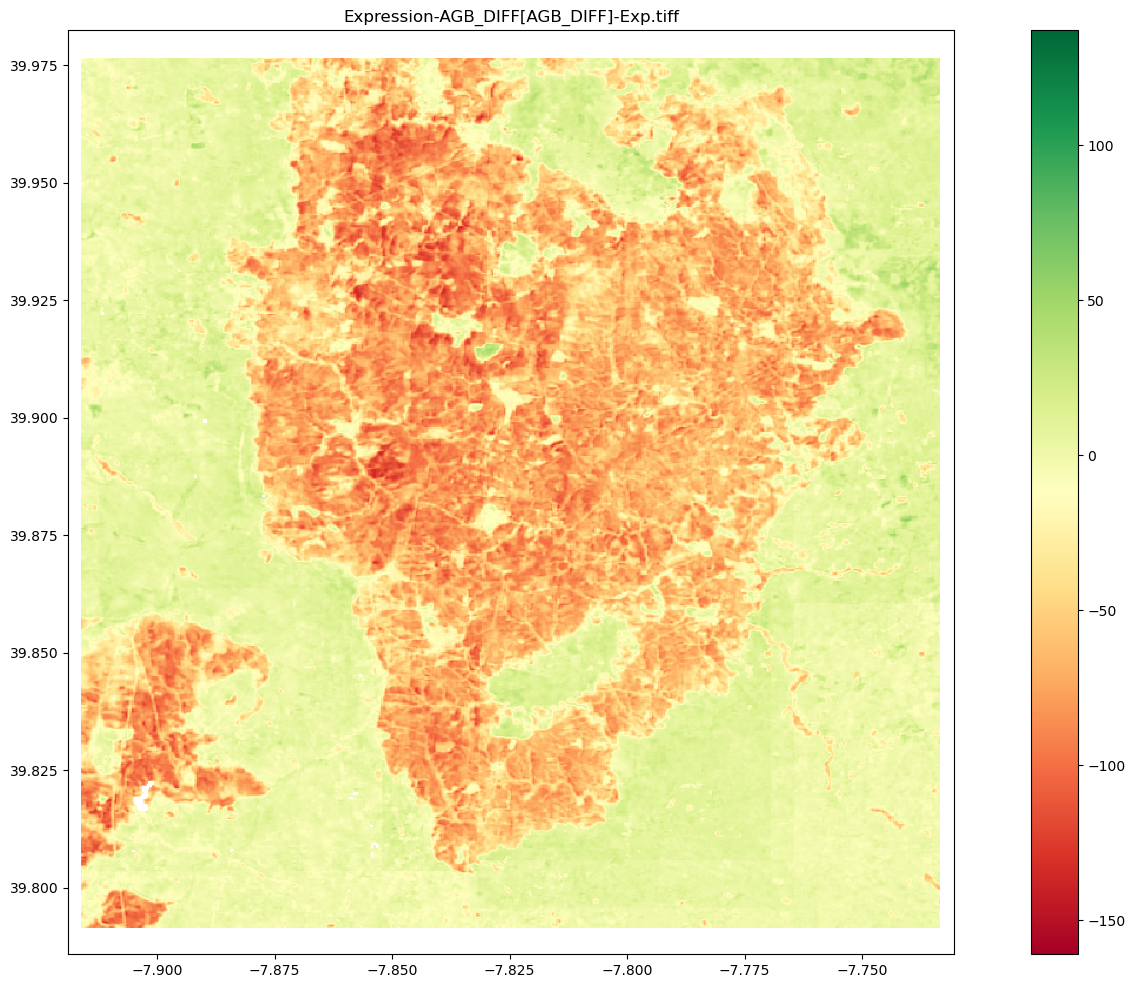

In [54]:
# Now display the resulting Tiff files.
historical_difference_title='Above Ground Biomass-species specific :'+str(agb_historical_difference_query_object.temporal.years)
historical_difference_files_list = agb_historical_difference_query_object.list_files()
historical_difference_files_list.sort()
for f in historical_difference_files_list:
    if f.endswith('.tiff'): #display the raster images
        with open(f+'.json', 'r') as ff:
            fileparms = json.load(ff)
        boundingBox=fileparms["boundingBox"]
        myextent=[boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ] 
        display_raster(f, colorMap='RdYlGn', Max=137, Min=-161, myextent=myextent)
            

As we can see in the above raster tiff file, the vegetation cover from the year 2020 has gone down to a rapid extent to the year 2021. All the Red area indicate the decrease in AGB cover impacted by wildfire, and all the Green area is the area unaffected by the wildfire which has no impact in the agb cover. This demonstrates how powerful the UDF expression in Geospatial APIs is, and how complex operations can be performed with minimal user interaction.

Below is the code snippet to overlay the tiff on a world map to get an interactive visual display, after which we display the screenshot of the same for ease of rendering the notebook

In [ ]:
#For visualizing maps
def create_fast_colormap_for_range(mycmmap_choice,vmin,vmax, empty_val):
    cm = mycmmap_choice.scale(vmin,vmax)   # cm.linear.Spectral_07.scale(0, 20)  # .to_step(1)   
    cmArray = []
    for i in range(vmin, vmax, 1):
        if i> vmax or i< vmin or  i == empty_val:   # i>20 or i==0:
            cmArray.insert(i,(1, 0, 0, 0)) 
        else:
            cmArray.insert(i,colors.to_rgba(cm(i), 0.8)) 
    return cmArray
cmArray = create_fast_colormap_for_range(cm.linear.RdYlGn_11, -149, 108, 0) #cm.linear.Spectral_07.scale(0,20)
agb_historical_difference_file_list = agb_historical_difference_query_object.list_files()
for file in agb_historical_difference_file_list:
    if file.endswith('.tiff'):
        with rasterio.open(file) as raster:
            # Display the boundaries of the raster image for a visual check
            rb = raster.bounds
            map = folium.Map( max_bounds=True,
                    location=[(rb.bottom+rb.top)/2, (rb.left+rb.right)/2],   # [40.8768,-73.6195],
                    zoom_start=11,
                    min_lat=rb.bottom, # min_lat,
                    max_lat=rb.top,    # max_lat,
                    min_lon=rb.left,   # min_lon,
                    max_lon=rb.right   #max_lon 
                    )
            data = raster.read(1)
            data[data==-9999] = np.nan_to_num(np.nan)
            data[data==0] = np.nan_to_num(np.nan)
            folium.raster_layers.ImageOverlay(
                        image=data.astype(np.uint8),opacity=0.7, 
                        colormap=lambda value: cmArray[value],
                        bounds=[[rb.bottom, rb.left], [rb.top, rb.right]]
                    ).add_to(map)
            map.add_child(cm.linear.RdYlGn_11.scale(-149, 108))
map

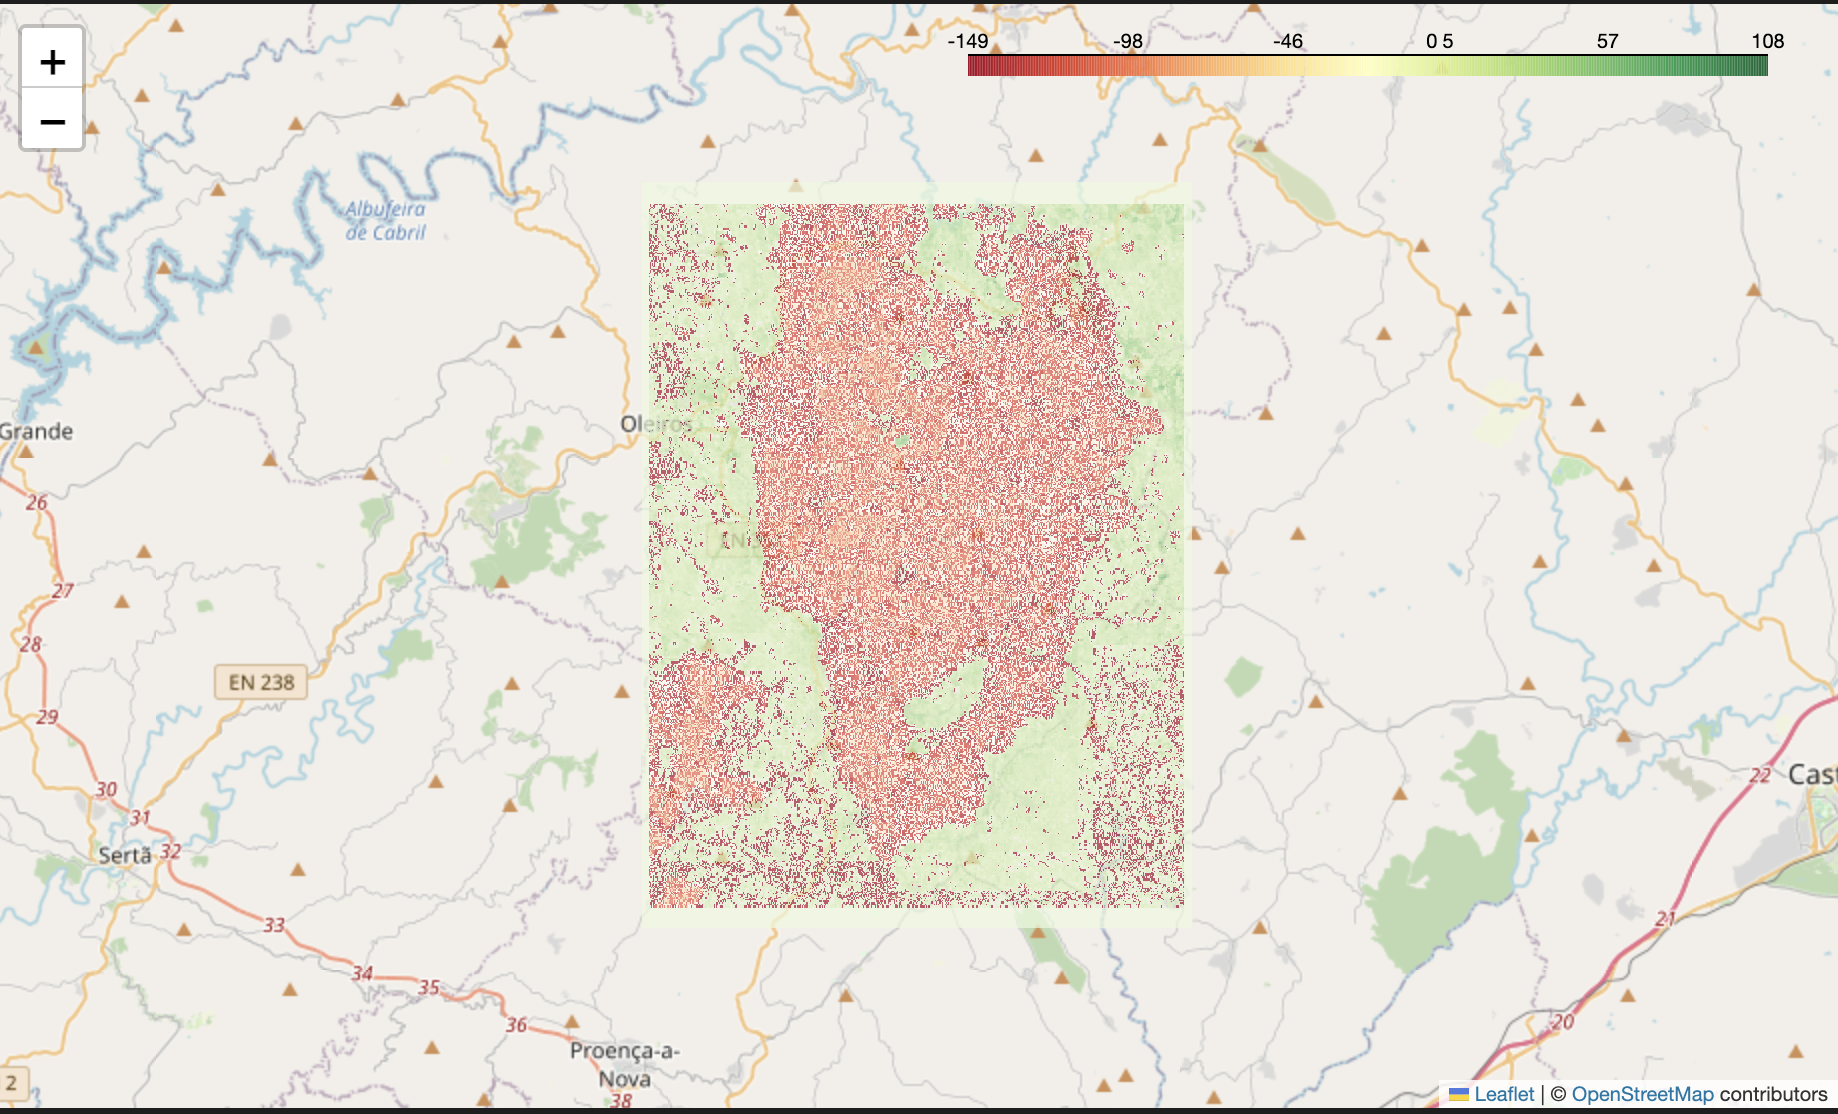

In [56]:
display.Image('historical_difference_in_agb.png')